# Facial Feature Faster R-CNN

In [1]:
import os
import yaml
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms.functional as F
import time
from collections import defaultdict
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
itrain='/kaggle/input/facial-feature-extraction-dataset/Facial Feature Extraction Dataset/train'
ivalid='/kaggle/input/facial-feature-extraction-dataset/Facial Feature Extraction Dataset/valid'
itest='/kaggle/input/facial-feature-extraction-dataset/Facial Feature Extraction Dataset/test'

In [3]:
import yaml

face_yaml = dict(
    train = itrain,
    val = ivalid,
    test = itest,
    nc = 5,
    names = ['eyes', 'eyebrows', 'lips', 'mustache-beard', 'nose']
)

with open('face.yaml', 'w') as outfile:
    yaml.dump(face_yaml, outfile, default_flow_style=True)
    
%cat face.yaml

{names: [eyes, eyebrows, lips, mustache-beard, nose], nc: 5, test: /kaggle/input/facial-feature-extraction-dataset/Facial
    Feature Extraction Dataset/test, train: /kaggle/input/facial-feature-extraction-dataset/Facial
    Feature Extraction Dataset/train, val: /kaggle/input/facial-feature-extraction-dataset/Facial
    Feature Extraction Dataset/valid}


In [4]:
class YoloToFasterRCNNDataset(Dataset):
    def __init__(self, images_dir, labels_dir, class_names, transforms=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.transforms = transforms
        self.class_names = class_names
        self.image_files = sorted([f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png", ".jpeg"))])
        self.label_files = sorted([f.replace('.jpg', '.txt').replace('.png', '.txt').replace('.jpeg', '.txt') 
                                 for f in self.image_files])

    def __len__(self):
        return len(self.image_files)

    def get_class_name(self, class_id):
        return self.class_names[class_id] if 0 <= class_id < len(self.class_names) else "unknown"

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        img = Image.open(img_path).convert("RGB")
        img_width, img_height = img.size

        # Load annotations
        label_path = os.path.join(self.labels_dir, self.label_files[idx])
        boxes, labels = [], []
        
        try:
            with open(label_path, "r") as f:
                for line in f.readlines():
                    if line.strip():
                        class_id, x_center, y_center, width, height = map(float, line.strip().split())
                        xmin = (x_center - width/2) * img_width
                        ymin = (y_center - height/2) * img_height
                        xmax = (x_center + width/2) * img_width
                        ymax = (y_center + height/2) * img_height
                        
                        xmin = max(0, min(xmin, img_width))
                        ymin = max(0, min(ymin, img_height))
                        xmax = max(0, min(xmax, img_width))
                        ymax = max(0, min(ymax, img_height))
                        
                        if xmax > xmin and ymax > ymin:
                            boxes.append([xmin, ymin, xmax, ymax])
                            labels.append(int(class_id) + 1)
        except Exception as e:
            print(f"Error reading {label_path}: {e}")
            boxes = [[0, 0, 1, 1]]
            labels = [0]

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)
        }

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

In [5]:
def collate_fn(batch):
    return tuple(zip(*batch))

def load_config(config_path):
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])

class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10):
    model.train()
    loss_meter = AverageMeter()
    
    start_time = time.time()
    for batch_idx, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Record loss
        loss_meter.update(losses.item())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if batch_idx % print_freq == 0:
            print(f'Epoch: [{epoch}][{batch_idx}/{len(data_loader)}]  '
                  f'Loss: {loss_meter.avg:.4f}  '
                  f'Time: {time.time() - start_time:.2f}s')

    return loss_meter.avg


def compute_iou(box1, box2):
    # box format: [xmin, ymin, xmax, ymax]
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    return intersection / (box1_area + box2_area - intersection)


def evaluate(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    
    class_metrics = defaultdict(lambda: {'true_positives': 0, 'false_positives': 0, 'false_negatives': 0})
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(images)
            
            for target, output in zip(targets, outputs):
                # Process each image
                pred_boxes = output['boxes'].cpu()
                pred_labels = output['labels'].cpu()
                pred_scores = output['scores'].cpu()
                
                true_boxes = target['boxes'].cpu()
                true_labels = target['labels'].cpu()
                
                # Match predictions to ground truth
                for label in torch.unique(true_labels):
                    class_name = str(label.item())
                    
                    # Get ground truth boxes for this class
                    true_class_mask = true_labels == label
                    true_class_boxes = true_boxes[true_class_mask]
                    
                    # Get predicted boxes for this class
                    pred_class_mask = pred_labels == label
                    pred_class_boxes = pred_boxes[pred_class_mask]
                    pred_class_scores = pred_scores[pred_class_mask]
                    
                    if len(pred_class_boxes) == 0:
                        class_metrics[class_name]['false_negatives'] += len(true_class_boxes)
                        continue
                    
                    # Sort predictions by score
                    sorted_idx = torch.argsort(pred_class_scores, descending=True)
                    pred_class_boxes = pred_class_boxes[sorted_idx]
                    
                    used_predictions = set()
                    used_targets = set()
                    
                    # Match each ground truth box to the best predicted box
                    for gt_idx, gt_box in enumerate(true_class_boxes):
                        best_iou = iou_threshold
                        best_pred_idx = None
                        
                        for pred_idx, pred_box in enumerate(pred_class_boxes):
                            if pred_idx in used_predictions:
                                continue
                                
                            iou = compute_iou(gt_box.numpy(), pred_box.numpy())
                            if iou > best_iou:
                                best_iou = iou
                                best_pred_idx = pred_idx
                        
                        if best_pred_idx is not None:
                            class_metrics[class_name]['true_positives'] += 1
                            used_predictions.add(best_pred_idx)
                            used_targets.add(gt_idx)
                        else:
                            class_metrics[class_name]['false_negatives'] += 1
                    
                    # Count false positives
                    class_metrics[class_name]['false_positives'] += len(pred_class_boxes) - len(used_predictions)
    
    # Calculate metrics for each class
    results = {}
    for class_name, metrics in class_metrics.items():
        tp = metrics['true_positives']
        fp = metrics['false_positives']
        fn = metrics['false_negatives']
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        results[class_name] = {
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    
    return results

In [7]:
def train_model(config_path, num_epochs=10, batch_size=2):
    # Load configuration
    config = load_config(config_path)
    
    train_path = config['train']
    val_path = config['val']
    num_classes = config['nc'] + 1
    class_names = config['names']
    
    # Initialize datasets
    train_dataset = YoloToFasterRCNNDataset(
        images_dir=os.path.join(train_path, 'images'),
        labels_dir=os.path.join(train_path, 'labels'),
        class_names=class_names,
        transforms=get_transform()
    )
    
    val_dataset = YoloToFasterRCNNDataset(
        images_dir=os.path.join(val_path, 'images'),
        labels_dir=os.path.join(val_path, 'labels'),
        class_names=class_names,
        transforms=get_transform()
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=1,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4
    )

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model = get_model(num_classes)
    model.to(device)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    best_f1 = 0.0
    print(f"Starting training with classes: {class_names}")
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
        
        # Evaluate
        metrics = evaluate(model, val_loader, device)
        
        # Calculate average F1 score
        avg_f1 = np.mean([m['f1'] for m in metrics.values()])
        
        print(f"Epoch {epoch} completed:")
        print(f"Train Loss: {train_loss:.4f}")
        print("Validation Metrics:")
        for class_name, class_metrics in metrics.items():
            print(f"Class {class_name}:")
            print(f"  Precision: {class_metrics['precision']:.4f}")
            print(f"  Recall: {class_metrics['recall']:.4f}")
            print(f"  F1: {class_metrics['f1']:.4f}")
        print(f"Average F1: {avg_f1:.4f}")
        
        # Save best model
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'class_names': class_names,
                'num_classes': num_classes,
                'metrics': metrics
            }, 'best_model.pth')
        
        # Save checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'class_names': class_names,
            'num_classes': num_classes,
            'metrics': metrics
        }, f'checkpoint_epoch_{epoch}.pth')
        
        lr_scheduler.step()
    
    print("Training completed")
    return model

In [8]:
def inference(model, image_path, class_names, device, confidence_threshold=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = get_transform()
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img_tensor)
        
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    
    label_names = [class_names[label-1] for label in labels]
    
    return boxes, label_names, scores

In [9]:
def get_color_map(class_names):
    """Assign fixed colors to each class."""
    np.random.seed(42)  
    colors = {}
    for i, name in enumerate(class_names):
        colors[name] = tuple(map(int, np.random.randint(0, 255, 3)))
    return colors

def visualize_predictions(image_path, boxes, labels, scores, class_names, confidence_threshold=0.5):
    """Draw prediction results on the image."""
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR to RGB
    
    # Get color map
    colors = get_color_map(class_names)
    
    # Draw prediction results
    for box, label, score in zip(boxes, labels, scores):
        if score < confidence_threshold:
            continue
            
        # Convert coordinates to integers
        x1, y1, x2, y2 = map(int, box)
        
        # Draw bounding box
        color = colors[label]
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        
        # Prepare text for label and score
        text = f'{label}: {score:.2f}'
        
        # Get background area size for the text
        (text_width, text_height), baseline = cv2.getTextSize(
            text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2
        )
        
        # Draw background for the text
        cv2.rectangle(
            image,
            (x1, y1 - text_height - baseline - 5),
            (x1 + text_width, y1),
            color,
            -1
        )
        
        # Draw the text
        cv2.putText(
            image,
            text,
            (x1, y1 - baseline - 5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (255, 255, 255),
            2
        )
    
    return image

def save_visualization(image, output_path):
    """Save the visualization result."""
    # Convert from RGB to BGR and save
    cv2.imwrite(output_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

def show_visualization(image):
    """Display the visualization result."""
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


In [10]:
def inference_with_visualization(model, image_path, class_names, device, confidence_threshold=0.5, 
                               visualize=True, save_path=None):
    """Perform inference and visualization."""
    # Perform inference
    model.eval()
    img = Image.open(image_path).convert("RGB")
    transform = get_transform()
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img_tensor)
        
    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()
    
    # Filter by score
    mask = scores >= confidence_threshold
    boxes = boxes[mask]
    labels = labels[mask]
    scores = scores[mask]
    
    # Convert class IDs to class names
    label_names = [class_names[label-1] for label in labels]
    
    if visualize:
        # Visualize prediction results
        vis_image = visualize_predictions(
            image_path, boxes, label_names, scores, 
            class_names, confidence_threshold
        )
        
        # Show results
        show_visualization(vis_image)
        
        # Save if save path is provided
        if save_path:
            save_visualization(vis_image, save_path)
    
    return boxes, label_names, scores, vis_image

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 219MB/s]


Starting training with classes: ['eyes', 'eyebrows', 'lips', 'mustache-beard', 'nose']
Epoch: [0][0/229]  Loss: 2.8002  Time: 2.11s
Epoch: [0][10/229]  Loss: 1.1734  Time: 5.50s
Epoch: [0][20/229]  Loss: 1.0266  Time: 9.06s
Epoch: [0][30/229]  Loss: 0.9540  Time: 12.65s
Epoch: [0][40/229]  Loss: 0.9054  Time: 16.26s
Epoch: [0][50/229]  Loss: 0.8894  Time: 19.88s
Epoch: [0][60/229]  Loss: 0.8499  Time: 23.52s
Epoch: [0][70/229]  Loss: 0.7896  Time: 27.19s
Epoch: [0][80/229]  Loss: 0.7521  Time: 30.86s
Epoch: [0][90/229]  Loss: 0.7196  Time: 34.58s
Epoch: [0][100/229]  Loss: 0.6836  Time: 38.30s
Epoch: [0][110/229]  Loss: 0.6533  Time: 42.04s
Epoch: [0][120/229]  Loss: 0.6268  Time: 45.79s
Epoch: [0][130/229]  Loss: 0.5995  Time: 49.56s
Epoch: [0][140/229]  Loss: 0.5813  Time: 53.36s
Epoch: [0][150/229]  Loss: 0.5639  Time: 57.20s
Epoch: [0][160/229]  Loss: 0.5553  Time: 61.05s
Epoch: [0][170/229]  Loss: 0.5404  Time: 64.90s
Epoch: [0][180/229]  Loss: 0.5257  Time: 68.78s
Epoch: [0][190/

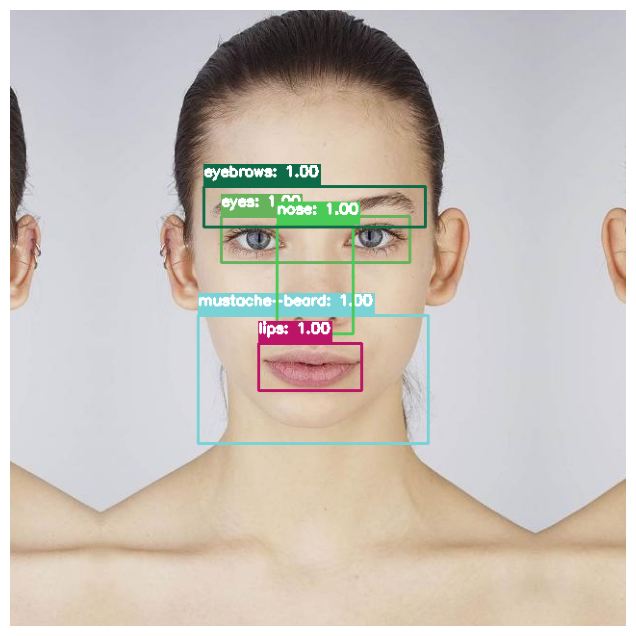


Results for test image 1:
Class: mustache-beard, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [195.43944 317.25778 434.7263  450.90698]
Class: eyes, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [219.67471 214.66362 415.29092 262.30795]
Class: nose, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [277.18686 222.68904 356.30423 336.5367 ]
Class: lips, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [258.43954 346.53757 365.19113 395.98703]
Class: eyebrows, Score: 0.998
Box coordinates [xmin, ymin, xmax, ymax]: [201.74515 183.35815 431.77716 225.31534]


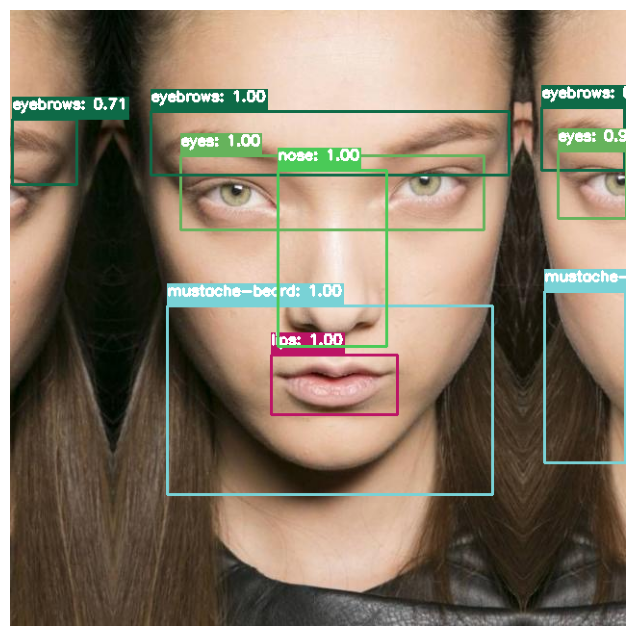


Results for test image 2:
Class: lips, Score: 1.000
Box coordinates [xmin, ymin, xmax, ymax]: [271.01495 358.62863 402.32394 420.13654]
Class: eyes, Score: 1.000
Box coordinates [xmin, ymin, xmax, ymax]: [177.86266 151.4169  492.1132  228.76848]
Class: mustache-beard, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [163.25964 307.89    501.93564 503.5562 ]
Class: eyebrows, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [146.35219  105.875145 518.0802   171.81815 ]
Class: nose, Score: 0.998
Box coordinates [xmin, ymin, xmax, ymax]: [278.986   166.34175 391.6246  349.4255 ]
Class: mustache-beard, Score: 0.996
Box coordinates [xmin, ymin, xmax, ymax]: [555.7751  292.50754 639.567   470.60983]
Class: eyebrows, Score: 0.995
Box coordinates [xmin, ymin, xmax, ymax]: [552.3021  101.06387 638.0263  166.31412]
Class: eyes, Score: 0.981
Box coordinates [xmin, ymin, xmax, ymax]: [569.2778  146.64377 640.      216.07353]
Class: eyebrows, Score: 0.715
Box coordinates [xmin, ymin, xm

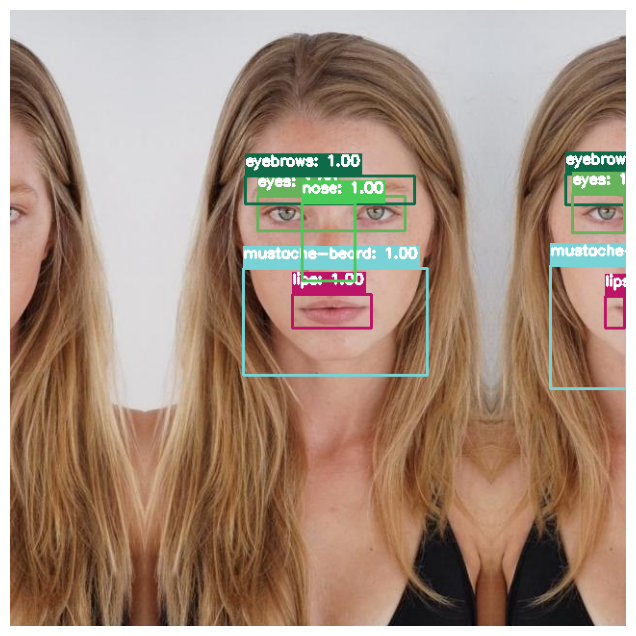


Results for test image 3:
Class: lips, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [293.80637 295.00842 375.13705 330.12015]
Class: eyes, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [257.6157  193.45393 410.76416 229.63997]
Class: mustache-beard, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [242.83696 268.4912  433.32574 379.55573]
Class: eyebrows, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [577.9277  170.0646  640.      202.38774]
Class: eyebrows, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [244.85843 172.4204  420.33185 201.44928]
Class: nose, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [303.8458  200.36919 358.72324 281.58798]
Class: eyes, Score: 0.998
Box coordinates [xmin, ymin, xmax, ymax]: [584.9956  191.07724 638.87823 231.40398]
Class: mustache-beard, Score: 0.962
Box coordinates [xmin, ymin, xmax, ymax]: [561.23456 265.77805 640.      393.6533 ]
Class: lips, Score: 0.605
Box coordinates [xmin, ymin, xmax, ymax

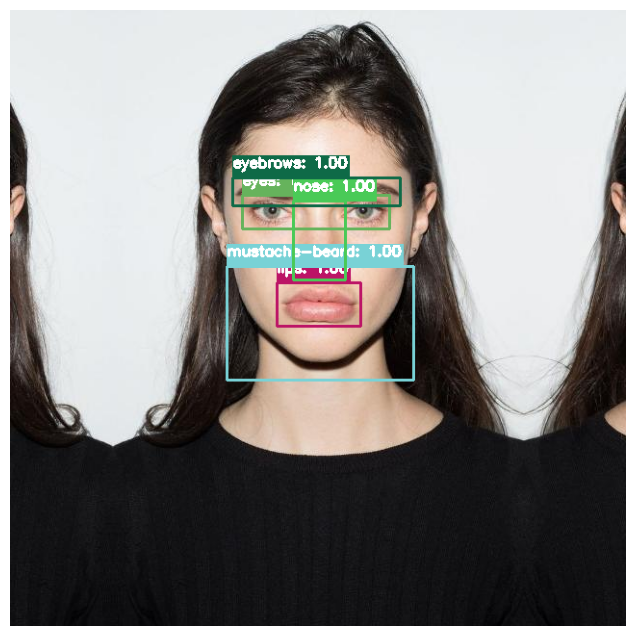


Results for test image 4:
Class: eyes, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [241.52315 192.65558 394.73593 227.71793]
Class: lips, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [277.4107  283.6545  364.4568  328.09616]
Class: mustache-beard, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [225.08511 266.38452 419.45596 384.4199 ]
Class: nose, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [294.97607 198.81665 348.2972  280.34982]
Class: eyebrows, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [231.9387  174.52603 405.37485 203.8457 ]


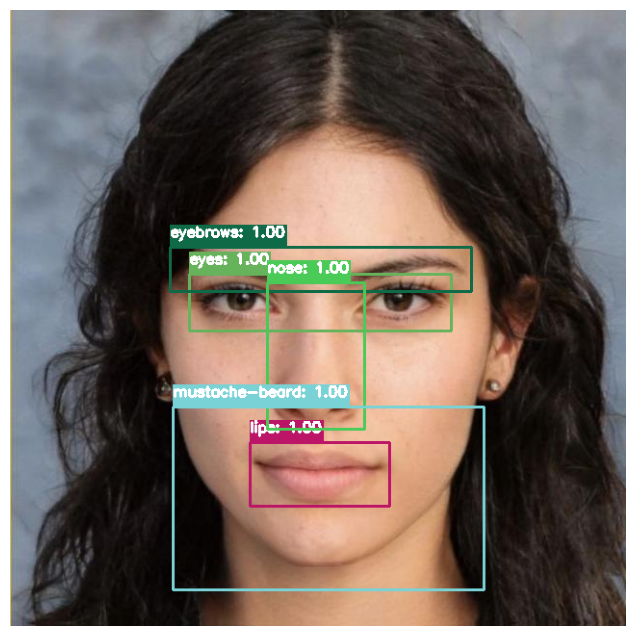


Results for test image 5:
Class: eyes, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [186.22923 274.8808  458.70508 333.45822]
Class: lips, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [249.96101 449.00903 394.35974 515.0673 ]
Class: eyebrows, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [166.16411 246.24718 479.79956 292.56232]
Class: nose, Score: 0.999
Box coordinates [xmin, ymin, xmax, ymax]: [267.64676 283.13663 368.5201  435.20285]
Class: mustache-beard, Score: 0.998
Box coordinates [xmin, ymin, xmax, ymax]: [169.5988  412.78442 492.4885  602.7865 ]


In [11]:
def main():
    config_path = 'face.yaml'
    num_epochs = 10
    batch_size = 2
    
    try:
        # Train the model
        model = train_model(config_path, num_epochs, batch_size)
        config = load_config(config_path)
        class_names = config['names']
        
        # Perform inference and visualization on the test set
        if 'test' in config:
            print("Running inference with visualization on test set...")
            device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
            test_dataset = YoloToFasterRCNNDataset(
                images_dir=os.path.join(config['test'], 'images'),
                labels_dir=os.path.join(config['test'], 'labels'),
                class_names=class_names,
                transforms=get_transform()
            )
            
            # Inference and visualization on test images
            if len(test_dataset) > 0:
                for i in range(min(5, len(test_dataset))):  # Test first 5 images
                    test_image_path = os.path.join(config['test'], 'images', test_dataset.image_files[i])
                    save_path = f'prediction_result_{i}.jpg'
                    
                    boxes, labels, scores, vis_image = inference_with_visualization(
                        model, 
                        test_image_path, 
                        class_names, 
                        device,
                        confidence_threshold=0.5,
                        visualize=True,
                        save_path=save_path
                    )
                    
                    print(f"\nResults for test image {i+1}:")
                    for box, label, score in zip(boxes, labels, scores):
                        print(f"Class: {label}, Score: {score:.3f}")
                        print(f"Box coordinates [xmin, ymin, xmax, ymax]: {box}")
            
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()
